# **Monitoring and Mapping Wildfires Using Satellite Data**


**Content creators:** Brittany Engle, Diana Cadillo

**Content reviewers:** Yuhan Douglas Rao, Abigail Bodner, Jenna Pearson, Chi Zhang, Ohad Zivan

**Content editors:** Zane Mitrevica, Natalie Steinemann, Jenna Pearson, Chi Zhang, Ohad Zivan

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS and Google DeepMind

In [ ]:
# @title Project Background
#This will be a short video introducing the content creator(s) and motivating the research direction of the template.

# @markdown
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'W5o_HTsef0I'), ('Bilibili', 'BV1ho4y1C7Eo')]
tab_contents = display_videos(video_ids, W=730, H=410)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

**In this project**, you will be working with wildfire remote sensing data from Sentinel 2 to extract Burn Perimeters using multiple Burn Indices and other relevant information related to wildfires. By integrating this data with information from other global databases, you will have the opportunity to explore the connections between wildfires and their impact on both the ecosystem and society.

# Project Template

![Project Template](https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/projects/template-images/wildfires_template_map.svg)

*Note: The dashed boxes are socio-economic questions.*

# Data Exploration Notebook
## Project Setup


In [ ]:
# installs
# !pip install gdal
# !pip install pandas
# !pip install geopandas

In [ ]:
# imports
import random
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import os
import matplotlib

## Satellite Data




**Global Wildfire Information System (GWIS)** is a global, joint initiative created by the GEO and the Copernicus Work Programs. The goal of this program is to bring together sources at a regional and international level to provide a global, comprehensive understanding of fire regimes and their effects. 

The Globfire dataset uses the MODIS burned area product (MCD64A1) to determine the amount of burnt area per event ([Artés et al., 2019](
https://www.nature.com/articles/s41597-019-0312-2)). The MCD64A1 product that Globfire is built on top of combines imagery from the Terra and Aqua satellites with thermal anomalies to provide burnt area information ([Website](https://modis-land.gsfc.nasa.gov/burn.html), [MODIS C6 BA User Guide](https://modis-land.gsfc.nasa.gov/burn.html) & [User Guide](http://modis-fire.umd.edu/files/MODIS_C6_BA_User_Guide_1.2.pdf)). 

**Sentinel 2**
Launched by the European Space Agency in June of 2015 (S2-A) and March of 2017 (S2-B), the Copernicus Sentinel-2 mission combines two polar-orbiting satellites to monitor variability in land surface conditions. Together, they have a global revisit time of roughly 5 days. 



In the provided Project Template, we load the following datasets:
- [Global Wildfire Information Systems](#dataset1-1)
- [Sentinel-2](#dataset1-2)


<a name="dataset1-1"></a>
## Global Wildfire Information Systems: Climate Action Large Wildfire Dataset


The Climate Action Large Wildfire Dataset is a filtered version of the Globfire dataset (created by GWIS). 


The resolution of this dataset is 500m. It has been pre-filtered to include only fires that are Class F or greater. Per the National Wildfire Coordinating Group, a Class F fire is defined as a fire that is 1,000 acres or greater, but less than 5,000 acres (note that a 2000m square region is roughly 1000 acres). For this dataset, all fires greater than 1,000 acres are included. Additional columns indicating area (acres), landcover number and landcover description, and country in which they are located within, were added. The landcover number and description were added using the Copernicus Global Land Cover Layers: CGLS-LC100 Collection 3 [User Guide](https://zenodo.org/record/3938963#.ZEeQEnZBwuU). 

Table Information: 
ID: Globfire fire ID (unique to each fire)

1. IDate: Globfire Initial (start) date of the fire
2. FDate: Globfire Final (end) date of the fire
3. Continent: Location of the fire 
4. Area_acres: size of fire in acres 
5. Landcover: land cover value from ESA, if the landcover of the fire cover is greater than 51%, then it is labeled as that landcover
6. LC_descrip: land cover description from ESA
7. Country: country the fire is located in

In [ ]:
# code to retrieve and load the data
url_climateaction='~/shared/Data/Projects/Wildfires/ClimateAction_countries.shp'
Dataset = gpd.read_file(url_climateaction) # need to update to OSF and pooch.retrieve 

We can now visualize the content of the dataset.



In [ ]:
# code to print the shape, array names, etc of the dataset
Dataset.head()

In [ ]:
# plot the dataset
Dataset.plot()

Great work! Now you are all set to address the questions you are interested in! Good luck!

<a name="dataset1-2"></a>
## Sentinel-2

Each of the two satellites contain a Multi-Spectral Instrument (MSI) that houses 13 spectral bands, at various resolutions. The MSI uses a push-broom acquisition technique and measures in the Visible and Near Infrared (NIR) and the Short Wave Infrared (SWIR) domains. There are:

- Four bands with 10m resolution: B2-Blue (490 nm), B3- Green (560 nm), B4- Red (665 nm) and Band 8- Near Infrared (NIR) (842 nm). 
- Six bands with 20m resolution: B5, B6, B7 and B8A (705 nm, 740 nm, 783 nm and 865 nm respectively) Vegetation Red Edge bands, along with B11 and B12 (1610 nm and 2190 nm) SWIR bands. These bands are mostly used for vegetation characterisation, vegetation stress assessment and ice/cloud/snow detection. 
- Three additional bands: B1 - Coastal Aerosol (443 nm), B9- Water Vapor (945 nm), and B10-SWIR-Cirrus (1375 nm) which are typically used for corrections of the atmosphere and clouds.


*[Sentinel-2](https://sentinel.esa.int/web/sentinel/missions/sentinel-2)

In [ ]:
# view image
def showImage(Output):
    plt.imshow(Output)
    plt.show()

In [ ]:
# data source-specific imports

# root folder location of where the imagery is currently saved
rootFolder = "~/shared/Data/Projects/Wildfires"

continet ="Asia"

# import pre images 
# pre_fire_paths = glob.glob(rootFolder + continet + id +"/pre_fire_*.npy")
pre_fire_paths = [fileName for fileName in os.listdir(os.path.join(rootFolder,continet)) if (fileName.endswith(".npy") & fileName.startswith('pre_fire_'))]
pre_fires_numpy = [numpy.load(os.path.join(rootFolder,continet,x)).astype(int) for x in pre_fire_paths]

# import post images 
post_fire_paths = [fileName for fileName in os.listdir(os.path.join(rootFolder,continet)) if (fileName.endswith(".npy") & fileName.startswith('post_fire_'))]
post_fires_numpy = [numpy.load(os.path.join(rootFolder,continet,x)).astype(int) for x in post_fire_paths]

# import Pre-SCL Mask for cloud coverage
scl_fire_paths = [fileName for fileName in os.listdir(os.path.join(rootFolder,continet)) if (fileName.endswith(".npy") & fileName.startswith('scl_pre_fire_'))]
scl_fires_numpy = [numpy.load(os.path.join(rootFolder,continet,x)) for x in scl_fire_paths]

# import Post-SCL Mask for cloud coverage
scl_fires_post_paths = [fileName for fileName in os.listdir(os.path.join(rootFolder,continet)) if (fileName.endswith(".npy") & fileName.startswith('scl_post_fire_'))]
scl_fires_post_numpy = [numpy.load(os.path.join(rootFolder,continet,x)) for x in scl_fires_post_paths]


In [ ]:
# print list of pre_fires
print("\n".join(pre_fire_paths))

In [ ]:
# print list of post_fire
print("\n".join(post_fire_paths))

In [ ]:
# print list of SCL
print("\n".join(scl_fire_paths))
print("\n".join(scl_fires_post_paths))


In [ ]:
# view pre-fire satellite image that was taken right before the fire start date
showImage(numpy.clip(pre_fires_numpy[2][:,:,[3,2,1]]/10000*3.5,0,1)) # RGB bands for Sentinel 2 are Bands: 4,3,2

In [ ]:
# view post-fire satellite image that was taken right before the fire start date
showImage(numpy.clip(post_fires_numpy[0][:,:,[3,2,1]]/10000*3.5,0,1)) # RGB bands for Sentinel 2 are Bands: 4,3,2


### Sentinel-2: Vegetation Health & Burnt Areas

[Sentinel-2 Imagery - Vegetation Health & Burnt Areas](https://drive.google.com/drive/folders/1u7UMz8gIkTPWUv6p5OhlE4jXaZAh-oP4?usp=sharing)

Continents included:

* Asia
* Africa
* Austrailia 
* Europe
* North America
* South America


**Vegetation Health:** Vegetation indices define and monitor the health of vegetation using the radiance values of the visible and near-infrared channels. The Normalized Difference Vegetation Index (NDVI) is used to measure “greenness” of vegetation.
As one of the most widely used vegetation indexes, the NDVI takes advantage of how strongly Chlorophyll absorbs visible light and how well the leafs cellular structure reflects near-infrared. Its values range from +1.0 to -1.0, with areas of sand, rock, and snow typically having a value of 0.1 or less. Shrubs and spare vegetation are roughly 0.2 to 0.5, while higher NDVI values (0.6 to 0.9) indicate dense vegetation that is typically found in tropical forests. 

The NDVI can also be used to create the Vegetation Condition Index (VCI). The VCI depends on the current NDVI along with the extreme NDVI values within the dataset (NDVImax and NDVImin). Specifically, $$VCI = \frac{NDVI-NDVImin}{NDVImax-NDVImin}\times 100\%$$ 

This number is then compared to the threshold to determine the drought severity. For this project, up to 3 months of pre-fire imagery will be used to determine current drought conditions.

*   [NDVI, the Foundation for Remote Sensing Phenology | U.S. Geological Survey](https://www.usgs.gov/special-topics/remote-sensing-phenology/science/ndvi-foundation-remote-sensing-phenology#overview)
*   [Application of NDVI in Vegetation Monitoring using Sentinel -2 Data for Shrirampur Region of Maharashtra](https://www.researchgate.net/publication/349763642_Application_of_NDVI_in_Vegetation_Monitoring_using_Sentinel_-2_Data_for_Shrirampur_Region_of_Maharashtra)


**Burnt Area Severity:** Burn severity describes how the intensity of the fire affects the functioning of the ecosystem in which it occurred. The degree to which it alters the ecosystem is typically found using a burn index, which then (typically) classes the severity of the fire as: unburned, low severity, moderate severity, or high severity.  One of the most common burn indices is the Normalized Burn Ratio (NBR). This index is designed to highlight burnt areas in fire zones. The formula is similar to NDVI, except that the formula combines the use of both near infrared (NIR) and shortwave infrared (SWIR) wavelengths. Healthy vegetation shows a very high reflectance in the NIR, and low reflectance in the SWIR portion of the spectrum - the opposite of what is seen in areas devastated by fire. Recently burnt areas demonstrate low reflectance in the NIR and high reflectance in the SWIR. The difference between the spectral responses of healthy vegetation and burnt areas reach their peak in the NIR and the SWIR regions of the spectrum. The difference between normalized burn ratios before and after a fire is called the dNBR, and is one of many useful indices. 

Specifically, the dNBR isolates the burned areas from the unburned areas, and subtracts the pre-fire imagery from the post-fire imagery. This removes any unchanged, and thus unburned, pixels as their values result in near zero. The results of the dNBR are based on burn severity, and correspond to the gradient of burn severity for every pixel. The dNBR has an unscaled range of -2.0 to +2.0 with burned areas tending to show more positively.

* [Fire intensity, fire severity and burn severity: A brief review and suggested usage](https://www.researchgate.net/publication/228638145_Fire_intensity_fire_severity_and_burn_severity_A_brief_review_and_suggested_usage)
* [Quantifying burn severity in a heterogeneous landscape with a relative version of the delta Normalized Burn Ratio (RdNBR)](https://www.researchgate.net/publication/222816542_Quantifying_burn_severity_in_a_heterogeneous_landscape_with_a_relative_version_of_the_delta_Normalized_Burn_Ratio_RdNBR)
* [A methodology to estimate forest fires burned areas and burn severity degrees using Sentinel-2 data. Application to the October 2017 fires in the Iberian Peninsula](https://www.researchgate.net/publication/346200185_A_methodology_to_estimate_forest_fires_burned_areas_and_burn_severity_degrees_using_Sentinel-2_data_Application_to_the_October_2017_fires_in_the_Iberian_Peninsula)


**SCL Mask**
Importing the SCL in order to mask out clouds form imagery

In [ ]:
# compute SCL Mask to 0s and 1s, masking out clouds and bad pixels
def computeSCLMask(image):
    rImage,cImage = image.shape
    sclOutput = numpy.zeros((rImage,cImage))
    for x in range(cImage):
        for y in range(rImage):
            sclOutput[y,x] = 1 if image[y,x] in [0,1,3,8,9,11] else 0
    
    return sclOutput

In [ ]:
# create Pre-fire and post-fire SCL masks
print(scl_fires_numpy[5])
pre_SCL_Mask = computeSCLMask(scl_fires_numpy[5])
post_SCL_Mask = computeSCLMask(scl_fires_post_numpy[0])

In [ ]:
#view SCL imagery for image closests to the start fire date
# -------  Save SCL as colored image based on SCL classification

# No Data (0) = black
# Saturated / Defective (1) = red
# Dark Area Pixels (2) = chocolate
# Cloud Shadows (3) = brown
# Vegetation (4) = lime
# Bare Soils (5) = yellow
# Water (6) = blue
# Clouds low probability / Unclassified (7) = aqua 
# clouds medium probability (8) = darkgrey
# Clouds high probability (9) light grey
# Cirrus (10) = deepskyblue
# Snow / Ice (11) = magenta
#  colors: https://matplotlib.org/3.1.1/gallery/color/named_colors.html#sphx-glr-gallery-color-named-colors-py

def showSCL(image):
    cmap = matplotlib.colors.ListedColormap(
        ["black", "red", "chocolate", "brown", "lime", "yellow", "blue","aqua","darkgrey","lightgrey","deepskyblue", "magenta"]) 
    plt.imshow(image, cmap=cmap)
    plt.show()

showSCL(scl_fires_numpy[5])


### Dataset-specific Functions: NDVI

In [ ]:
# this code computes the NDVI for an image
'The NDVI can be computed on any image (pre or post).'
'Compute the NDVI on the pre-fire image'

#compute NDVI
def computeNDVI(image, mask):
    r,c,ch = image.shape
    ndviOutput = numpy.zeros((r,c))
    for x in range(c):
        for y in range(r):
            if (image[y,x,7] ==0 and image[y,x,3] == 0) or mask[y,x] == 1: 
                ndviOutput[y,x] = numpy.nan
            else: 
                ndviOutput[y,x] = (image[y,x,7] - image[y,x,3]) / (image[y,x,7] + image[y,x,3])
    
    return ndviOutput

In [ ]:
#TA Code
computeNDVI_value = computeNDVI(pre_fires_numpy[2],pre_SCL_Mask)

In [ ]:
# plot NDVI without remap
showImage(computeNDVI_value)

In [ ]:
# use this code to remap the NDVI to specific colors for values
def remapNDVI(NDVI):
    remapped = numpy.zeros((NDVI.shape[0], NDVI.shape[1]))
    for x in range(remapped.shape[0]):
        for y in range(remapped.shape[1]):
            if numpy.isnan(NDVI[x, y]):
                remapped[x, y] = numpy.nan
            elif NDVI[x, y] <= -0.2:
                remapped[x, y] = 1
            elif NDVI[x, y] <= 0:
                remapped[x, y] = 2
            elif NDVI[x, y] <= .1:
                remapped[x, y] = 3
            elif NDVI[x, y] <= 0.2:
                remapped[x, y] = 4
            elif NDVI[x, y] <= 0.3:
                remapped[x, y] = 5
            elif NDVI[x, y] <= 0.4:
                remapped[x, y] = 6
            elif NDVI[x, y] <= 0.5:
                remapped[x, y] = 7
            elif NDVI[x, y] <= 0.6:
                remapped[x, y] = 8
            elif NDVI[x, y] <= 0.7:
                remapped[x, y] = 9
            elif NDVI[x, y] <= 0.8:
                remapped[x, y] = 10
            elif NDVI[x, y] <= 0.9:
                remapped[x, y] = 11
            elif NDVI[x, y] <= 1:
                remapped[x, y] = 12
            else :
                remapped[x,y] = 13
    return remapped

In [ ]:
#TA Code
NDVI_remap = remapNDVI(computeNDVI_value)

In [ ]:
# view remapped NDVI
def showNDVI(image):
    cmap = matplotlib.colors.ListedColormap(
        ["#000000", "#a50026", "#d73027", "#f46d43", "#fdae61", "#fee08b", "#ffffbf","#d9ef8b","#a6d96a","#66bd63","#1a9850", "#006837"]) 
    plt.imshow(image, cmap=cmap)
    plt.show()

showNDVI(NDVI_remap)

### Dataset-specific Functions: VCI

In [ ]:
# compute the SCL mask for all the SCLs and apply it to the pre_fire_NDVIs
pre_fires_scl = [computeSCLMask(x) for x in scl_fires_numpy]
pre_fires_NDVI = [computeNDVI(x[0],x[1]) for x in zip(pre_fires_numpy,pre_fires_scl)]

In [ ]:
# compute for VCI
def computeVCI(for_ndvi_image, ndvi_dataset ):
    rImage,cImage =for_ndvi_image.shape
    vciOutput = numpy.zeros((rImage,cImage))
    ndvi_dataset.append(for_ndvi_image)
    for x in range(cImage):
        for y in range(rImage):
            pixels = [z[y,x] for z in ndvi_dataset]
            filtered_pixels = [f for f in pixels if not numpy.isnan(f)]
            if len(filtered_pixels) == 0 or len(filtered_pixels) == 1:
                vciOutput[y,x] = 1
            elif numpy.isnan(for_ndvi_image[y,x]):
                vciOutput[y,x] = 1
            else:
                max_val = max(filtered_pixels)
                min_val = min(filtered_pixels)
                if max_val == min_val:
                    vciOutput[y,x] = 1
                else:
                    vciOutput[y,x] = (for_ndvi_image[y,x] - min_val)/(max_val-min_val)
    
    return vciOutput

### VCI Drought Threshold
* image and more information: [Spatial and Temporal Variation of Drought Based onSatellite Derived Vegetation Condition Index in Nepal from 1982–2015](https://www.researchgate.net/publication/330521783_Spatial_and_Temporal_Variation_of_Drought_Based_on_Satellite_Derived_Vegetation_Condition_Index_in_Nepal_from_1982-2015)

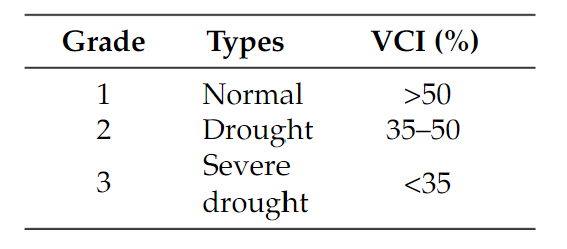

In [ ]:
# compute the VCI for the last pre-fire to view the drought over the time period
last_pre_fire_NDVI = pre_fires_NDVI.pop(2)
last_pre_fire_vci = computeVCI(last_pre_fire_NDVI, pre_fires_NDVI)

In [ ]:
# view the non-thresholded VCI
showImage(last_pre_fire_vci)

In [ ]:
# map specific colors to values to show the severity of the droughts
def remapVCI(vci):
    remapped = numpy.zeros(vci.shape)
    for x in range(remapped.shape[0]):
        for y in range(remapped.shape[1]):
            if vci[x,y] < 0.35:
                remapped[x,y] = 1
            elif vci[x,y] <= 0.50:
                remapped[x,y] = 2
            else:
                remapped[x,y] = 3
    return remapped

In [ ]:
# define the VCI mapped/thresholded values
def showVCI(vci_image):
    cmap = matplotlib.colors.ListedColormap(
        ["red","yellow","green"]
    )
    plt.imshow(remapVCI(vci_image), cmap=cmap)
    plt.show()

In [ ]:
# view the mapped VCI values
showVCI(last_pre_fire_vci)

### Dataset-specific Functions: NBR and dNBR Code


In [ ]:
# this code creates the NBR for each image then uses the NBR to create the dNBR. It can easily be updated for other burnt area indices

def computeFireMasks(pre_fire, post_fire):

    rows, columns, channels = pre_fire.shape
    nbrPost = numpy.zeros((rows, columns))
    nbrPre = numpy.zeros((rows, columns))
    dnbr = numpy.zeros((rows,columns))

    for x in range(columns):
        for y in range(rows):
          nbrPost[y, x] = (post_fire[y, x, 7] - post_fire[y, x, 11])/(post_fire[y, x, 7] + post_fire[y, x, 11])
          nbrPre[y, x] = (pre_fire[y, x, 7] - pre_fire[y, x, 11])/(pre_fire[y, x, 7] + pre_fire[y, x, 11])
          dnbr[y, x] = nbrPre[y, x] - nbrPost[y, x]         

    return dnbr


In [ ]:
# TA Code 
#run computeFireMasks
dnbr = computeFireMasks(pre_fires_numpy[2], post_fires_numpy[0])

In [ ]:
# this code applies a threshold to the dNBR to show the level of burn intensity (unburned, low severity, moderate severity, or high severity)

def remapDNBR(dnbr):
    remapped = numpy.zeros((dnbr.shape[0], dnbr.shape[1]))
    for x in range(remapped.shape[0]):
        for y in range(remapped.shape[1]):
            if numpy.isnan(dnbr[x, y]):
                remapped[x, y] = numpy.nan
            elif dnbr[x, y] <= -0.251:
                remapped[x, y] = 1
            elif dnbr[x, y] <= -0.101:
                remapped[x, y] = 2
            elif dnbr[x, y] <= 0.099:
                remapped[x, y] = 3
            elif dnbr[x, y] <= 0.269:
                remapped[x, y] = 4
            elif dnbr[x, y] <= 0.439:
                remapped[x, y] = 5
            elif dnbr[x, y] <= 0.659:
                remapped[x, y] = 6
            elif dnbr[x, y] <= 1.3:
                remapped[x, y] = 7
            else :
                remapped[x,y] = 8
    return remapped

In [ ]:
#TA Code
dnbr_remapped = remapDNBR(dnbr)

### dNBR Threshold
* image and more information: [Normalized Burn Ratio (NBR) UN-SPIDER Knowledge Portal](https://un-spider.org/advisory-support/recommended-practices/recommended-practice-burn-severity/in-detail/normalized-burn-ratio)

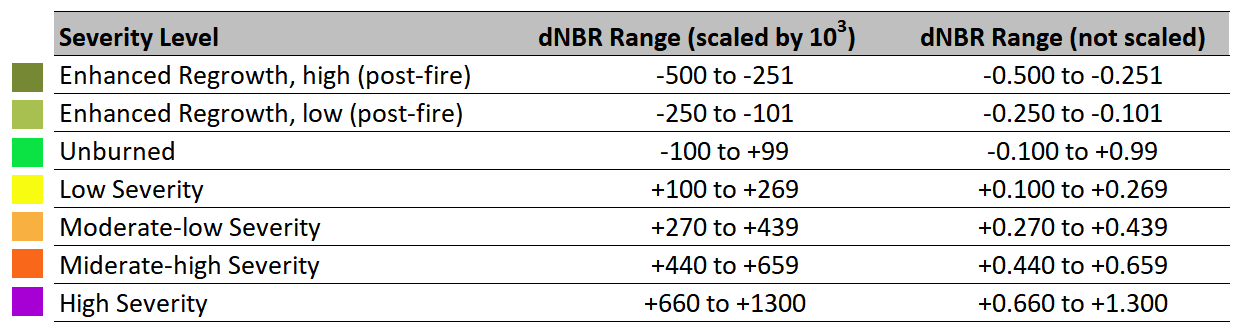

In [ ]:
# this code takes the above function (remapDNBR) where the dNBR threshold has been applied to the image'
# and applies a color coded map to each threshold as shown in the image above'

def showDNBR(dnbr):
    cmap = matplotlib.colors.ListedColormap(
        ["blue", "teal", "green", "yellow", "orange", "red", "purple",]
    )
    plt.imshow(remapDNBR(dnbr), cmap=cmap)

showDNBR(dnbr_remapped)

# Further Reading


*   [Forest ecosystems, disturbance, and climate change in Washington State, USA | US Forest Service Research and Development Fire Ecology and Monitoring at Yosemite](https://www.fs.usda.gov/research/treesearch/38936)
*   [Fire Ecology and Monitoring at Yosemite](https://www.nps.gov/yose/learn/nature/fireecology.htm)
*   [A Project for Monitoring Trends in Burn Severity | Fire Ecology | Full Text](https://fireecology.springeropen.com/articles/10.4996/fireecology.0301003)
*   [The unequal vulnerability of communities of color to wildfire | PLOS ONE ](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0205825)
*   [Fire Frequency, Area Burned, and Severity: A Quantitative Approach to Defining a Normal Fire Year](https://fireecology.springeropen.com/articles/10.4996/fireecology.0702051)
*   [Identifying Key Drivers of Wildfires in the Contiguous US Using Machine Learning and Game Theory Interpretation - Wang - 2021 - Earth's Future - Wiley Online Library](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2020EF001910)
*   [Science, technology, and human factors in fire danger rating: the Canadian experience](https://www.researchgate.net/publication/237505534_Science_technology_and_human_factors_in_fire_danger_rating_the_Canadian_experience)
*   [Wildfire Selectivity for Land Cover Type: Does Size Matter?](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0084760)
*   [Vegetation, topography and daily weather influenced burn severity in central Idaho and western Montana forests](https://esajournals.onlinelibrary.wiley.com/doi/full/10.1890/ES14-00213.1)


Socio-economic effects of wildfires

* Zhao, J. et al. (2020). Quantifying the Effects of Vegetation Restorations on the Soil Erosion Export and Nutrient Loss on the Loess Plateau. Front. Plant Sci. 11 [https://doi.org/10.3389/fpls.2020.573126](https://www.frontiersin.org/articles/10.3389/fpls.2020.573126/full)
* Amanda K. Hohner, Charles C. Rhoades, Paul Wilkerson, Fernando L. Rosario-Ortiz (2019). Wildfires alter forest watersheds and threaten drinking water quality. Accounts of Chemical Research. 52: 1234-1244. [https://doi.org/10.1021/acs.accounts.8b00670](https://doi.org/10.1021/acs.accounts.8b00670)
* Alan Buis (2021). The Climate Connections of a Record Fire Year in the U.S. West. [Link](https://climate.nasa.gov/explore/ask-nasa-climate/3066/the-climate-connections-of-a-record-fire-year-in-the-us-west/)
* Ian P. Davies ,Ryan D. Haugo,James C. Robertson,Phillip S. Levin (2018). The unequal vulnerability of communities of color to wildfire.PLoS ONE 13(11): e0205825. [https://doi.org/10.1371/journal.pone.0205825](https://doi.org/10.1371/journal.pone.0205825)


Wildfires and forest ecosystems
*   [Controlled fires](https://smokeybear.com/es/about-wildland-fire/benefits-of-fire/prescribed-fires)
*   [Argentina on fire: what the fire left us | Spanish (pdf)](https://farn.org.ar/wp-content/uploads/2020/12/DOC_ARGENTINA-INCENDIADA_links.pdf)
*   [Forest fires and biological diversity](https://www.fao.org/3/y3582s/y3582s08.htm)

